(mmm_multi_objective_optimization)=
# Multi-Objective optimization with PyMC-Marketing

Have you ever faced the challenge of deciding whether to focus on bringing in new users or keeping the ones you already have? It’s a common dilemma in any growing company. On one hand, acquisition drives visibility, expansion, and excitement. On the other, retention builds loyalty, stability, and long-term value. When resources are limited, choosing where to invest—more ads to attract newcomers or more experiences to keep your current audience engaged—feels like walking a tightrope between short-term gains and lasting growth.

This kind of trade-off isn’t unique to marketing. Product teams constantly balance innovation and reliability. Operations managers weigh efficiency against flexibility. Data scientists tune models to maximize accuracy while minimizing bias or computational cost. These are all examples of competing objectives that must coexist within finite resources. Multi-objective optimization provides a systematic framework for navigating these tensions. It allows decision-makers to explore how improving one goal may compromise another, and to find balanced solutions along the Pareto frontier—the set of decisions where no objective can be improved without sacrificing another. In essence, it transforms difficult trade-offs into informed, strategic choices.

This notebook explores multi-objective optimization using PyMC and PyMC-Marketing, focusing on the trade-off between acquiring new users and retaining existing ones. It demonstrates how to balance competing objectives and includes practical examples of building and optimizing models (both custom and default) to achieve balanced solutions in marketing scenarios.

## Import dependencies


In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from pymc_extras.prior import Censored, Prior
from pytensor import function

from pymc_marketing import mmm
from pymc_marketing.mmm.budget_optimizer import (
    BudgetOptimizer,
    BuildMergedModel,
    CustomModelWrapper,
)
from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml
from pymc_marketing.mmm.constraints import Constraint
from pymc_marketing.mmm.multidimensional import MultiDimensionalBudgetOptimizerWrapper
from pymc_marketing.mmm.utility import _check_samples_dimensionality
from pymc_marketing.paths import data_dir
from pymc_marketing.pytensor_utils import merge_models

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_22598/1835901904.py:18: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml


## Notebook settings

In [ ]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "mmm_multi_objective_optimization"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Optimizing Custom PyMC Models
First, we'll show some of the under-the-hood functions and how you can apply them to your custom PyMC model.

To do so, we first need to generate a simple model and some data.

In [ ]:
n_observations = 100
date_range = pd.date_range(start="2020-01-01", periods=n_observations, freq="D")

In [ ]:
def random_walk(mu, sigma, steps, lower=None, upper=None, seed=None):
    """
    Generate a bounded random walk with specified mean and standard deviation.

    Parameters
    ----------
    mu : float
        Target mean of the random walk
    sigma : float
        Target standard deviation of the random walk
    steps : int
        Number of steps in the random walk
    lower : float, optional
        Lower bound for the random walk values
    upper : float, optional
        Upper bound for the random walk values
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    np.ndarray
        Random walk array with specified mean, std, and bounds
    """
    # if seed none then set 123
    if seed is None:
        seed = 123
    # Create a random number generator with the given seed
    rng = np.random.RandomState(seed)

    # Start from the target mean
    walk = np.zeros(steps)
    walk[0] = mu

    # Generate the walk step by step with bounds checking
    for i in range(1, steps):
        # Generate a random increment using the seeded RNG
        increment = rng.normal(0, sigma * 0.1)  # Scale increment size

        # Propose next value
        next_val = walk[i - 1] + increment

        # Apply bounds if specified
        if lower is not None and next_val < lower:
            # Reflect off lower bound
            next_val = lower + (lower - next_val)
        if upper is not None and next_val > upper:
            # Reflect off upper bound
            next_val = upper - (next_val - upper)

        # Final bounds check (hard clipping as backup)
        if lower is not None:
            next_val = max(next_val, lower)
        if upper is not None:
            next_val = min(next_val, upper)

        walk[i] = next_val

    # Adjust to match target mean and std while respecting bounds
    current_mean = np.mean(walk)
    current_std = np.std(walk)

    if current_std > 0:
        # Center around zero, scale to target std, then shift to target mean
        walk_centered = (walk - current_mean) / current_std * sigma + mu

        # Apply bounds again after scaling
        if lower is not None:
            walk_centered = np.maximum(walk_centered, lower)
        if upper is not None:
            walk_centered = np.minimum(walk_centered, upper)

        walk = walk_centered

    return walk

We set the `impressions` variable as a set of independent random walks, each with a specific mean and standard deviation.

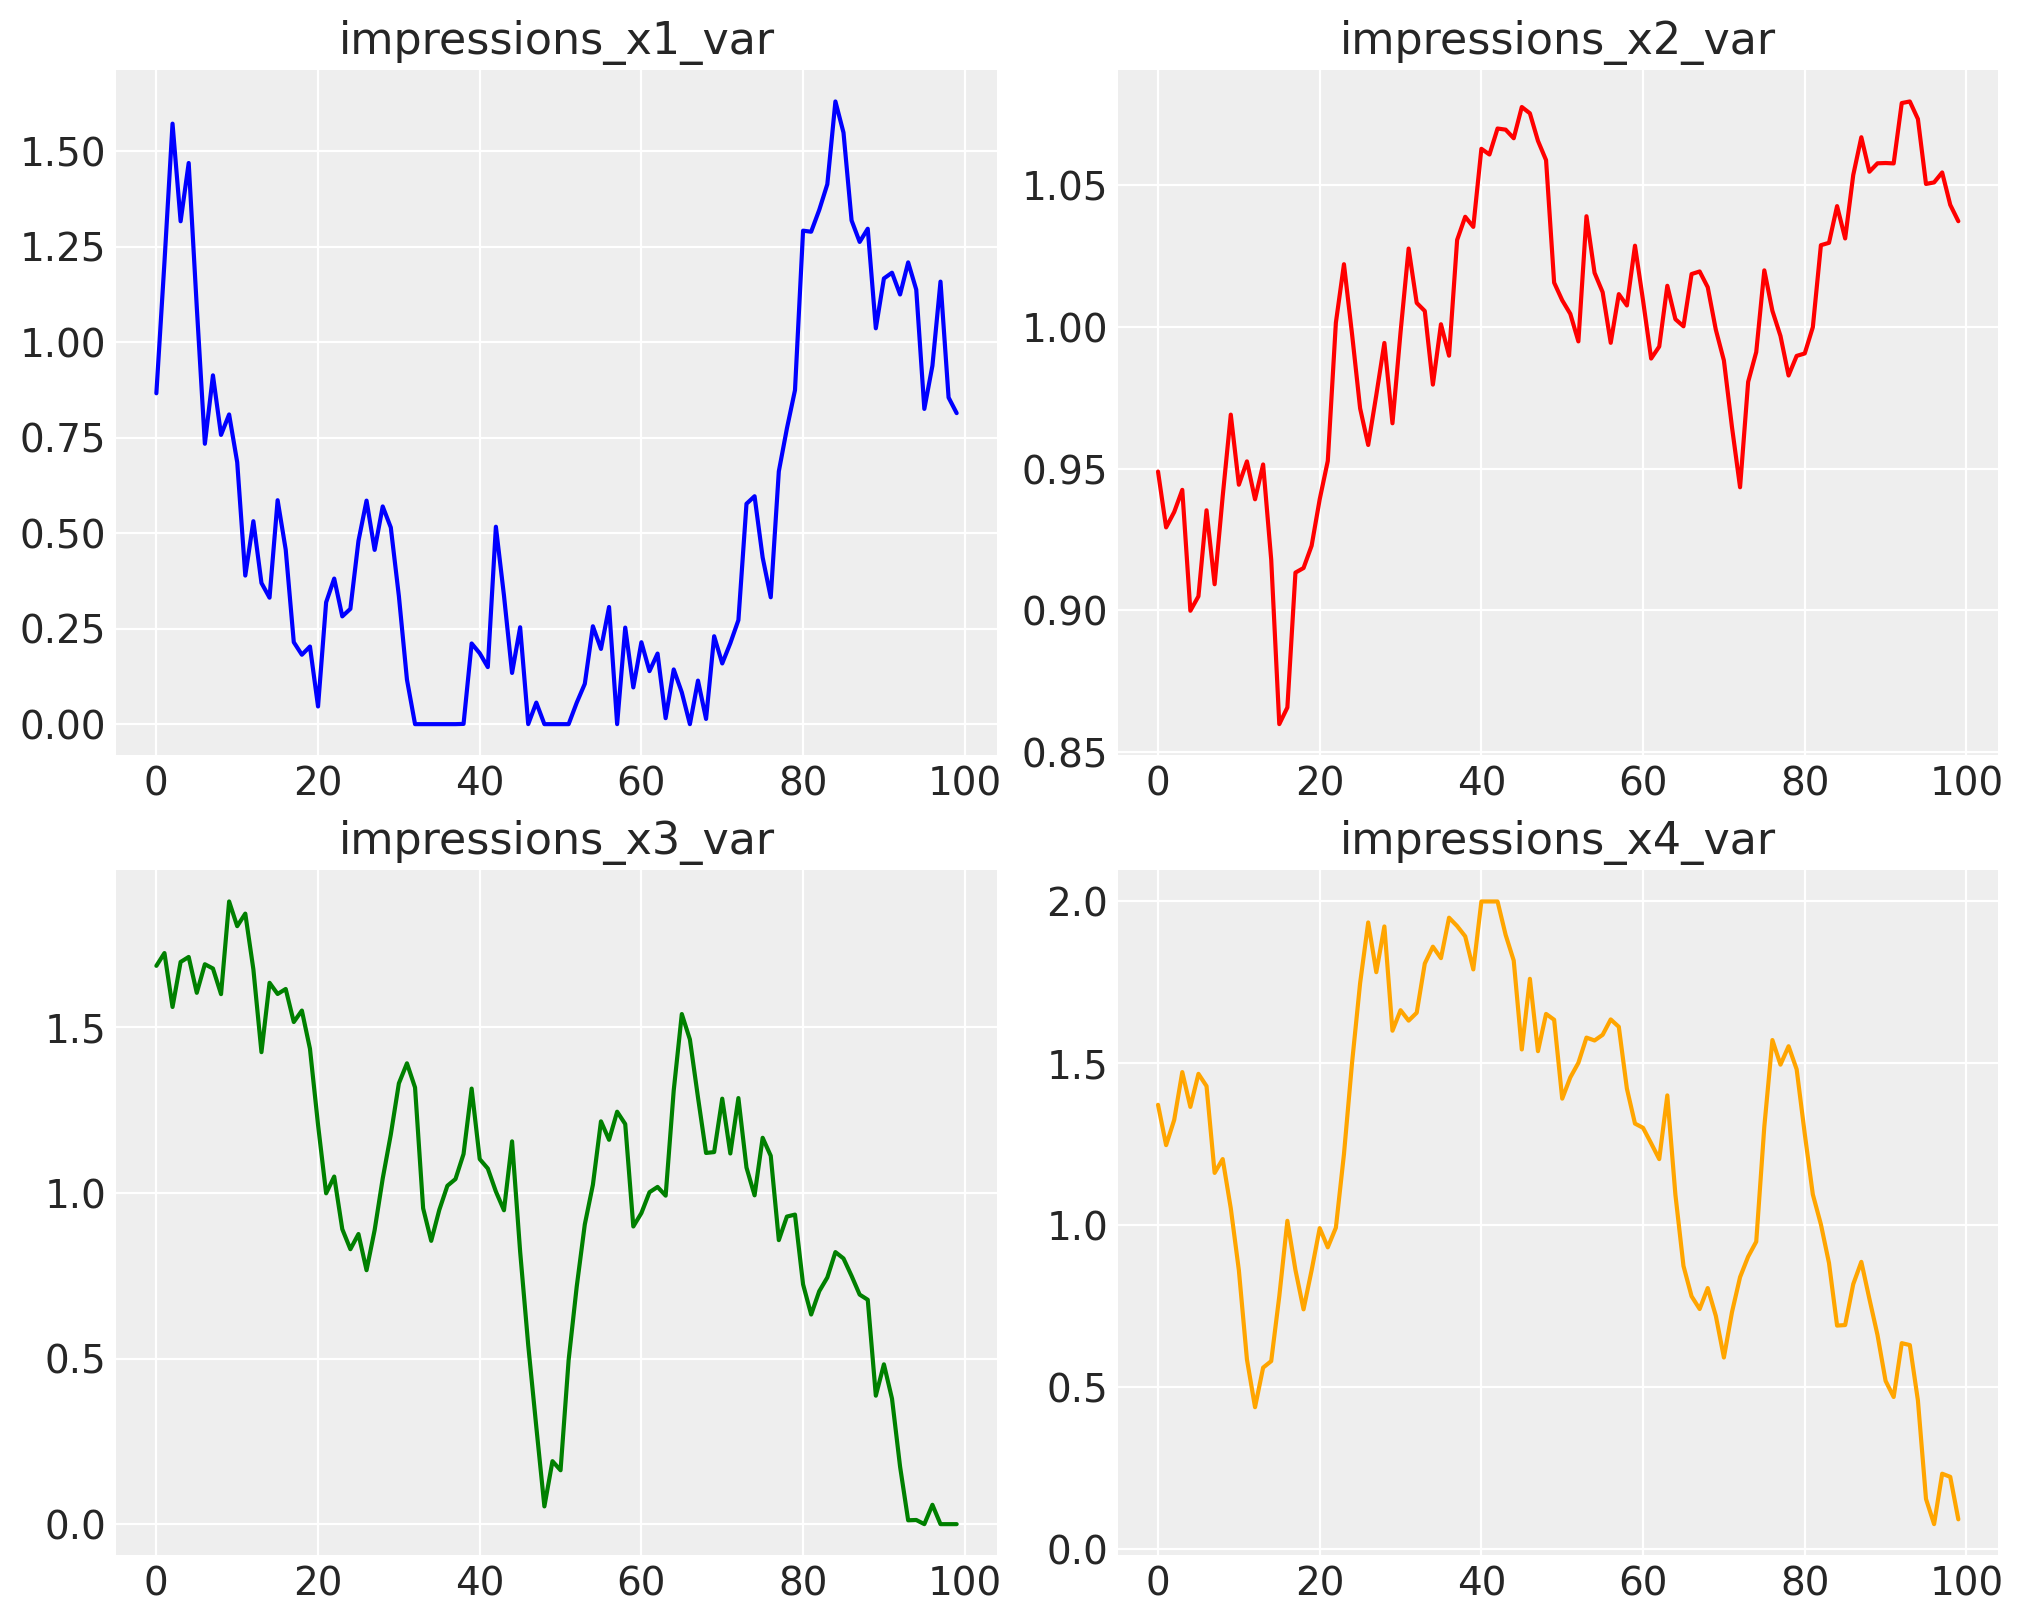

In [ ]:
impressions_x1_var = random_walk(
    mu=0.5, sigma=0.5, steps=n_observations, lower=0, upper=2, seed=seed + 1
)
impressions_x2_var = random_walk(
    mu=1, sigma=0.05, steps=n_observations, lower=0, upper=2, seed=seed + 2
)
impressions_x3_var = random_walk(
    mu=1, sigma=0.5, steps=n_observations, lower=0, upper=2, seed=seed - 3
)
impressions_x4_var = random_walk(
    mu=1.2, sigma=0.5, steps=n_observations, lower=0, upper=2, seed=seed - 1
)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(impressions_x1_var, color="blue")
axs[0, 0].set_title("impressions_x1_var")
axs[0, 1].plot(impressions_x2_var, color="red")
axs[0, 1].set_title("impressions_x2_var")
axs[1, 0].plot(impressions_x3_var, color="green")
axs[1, 0].set_title("impressions_x3_var")
axs[1, 1].plot(impressions_x4_var, color="orange")
axs[1, 1].set_title("impressions_x4_var")
plt.show()

Once we have all the data in place, we can consolidate it into a dataframe. This will help us define our model structure, which in this case will depend only on impressions from channels $x1$, $x2$, $x3$, and $x4$.

In [ ]:
dataset = pd.DataFrame(
    {
        "date": date_range,
        "impressions_x1_var": impressions_x1_var,
        "impressions_x2_var": impressions_x2_var,
        "impressions_x3_var": impressions_x3_var,
        "impressions_x4_var": impressions_x4_var,
    }
)
dataset["y"] = 0
dataset.head()

,date,impressions_x1_var,impressions_x2_var,impressions_x3_var,impressions_x4_var,y
0,2020-01-01,0.866098,0.948983,1.686121,1.372259,0
1,2020-01-02,1.208886,0.929276,1.724699,1.247626,0
2,2020-01-03,1.571934,0.934704,1.561938,1.325415,0
3,2020-01-04,1.316408,0.942521,1.697812,1.473127,0
4,2020-01-05,1.468910,0.899849,1.712968,1.365724,0


The initial model constructed in this notebook is a straightforward Bayesian model designed to capture the relationship between input features and a target variable. The model is defined as:

$$
Y \sim f(X, \theta) + \epsilon
$$

Where:
- $Y$ is the target variable.
- $X$ represents the input features.
- $\theta$ denotes the model parameters.
- $\epsilon$ denotes the base sales, which are not dependent on marketing.

The function $f(X, \theta)$ is a deterministic transformation of the input features $X$ using the parameters $\theta$, which in this context, is modeled using a Michaelis-Menten saturation function. This function is particularly useful for capturing diminishing returns in marketing scenarios, where the effect of increasing input (e.g., advertising spend) on the output (e.g., sales) eventually plateaus.

Since the model is a simple saturation function, we only need to define priors for its parameters, the intercept, and the aleatoric uncertainty.

In [ ]:
alpha_prior = Prior("Beta", alpha=2, beta=1, dims="channel")
lam_prior = Prior("Gamma", mu=1, sigma=0.5, dims="channel")
priors = {
    "lam": lam_prior,
    "alpha": alpha_prior,
}

saturation = mmm.MichaelisMentenSaturation(priors=priors)

coordinates = {
    "date": date_range,
    "channel": dataset.drop(columns=["date", "y"]).columns.tolist(),
}

intercept = Prior("Normal", mu=0, sigma=1)
noise = Prior("HalfNormal", sigma=1)
likelihood = Censored(
    Prior(
        "Normal",
        sigma=noise,
        dims="date",
    ),
    lower=0,
)

With all our priors defined, we can create the model structure. Both models will share the same structure but will have different target variables. (We can create a function to generate the same base model based on certain inputs).

In [ ]:
def build_simple_mmm(dataset, coordinates, target_column):
    with pm.Model(coords=coordinates) as base_model:
        data = pm.Data(
            "channel_data", dataset[coordinates["channel"]], dims=("date", "channel")
        )
        target = pm.Data("target", dataset[target_column], dims="date")
        contribution = pm.Deterministic(
            "contribution",
            var=saturation.apply(data),
            dims=("date", "channel"),
        )

        _intercept = intercept.create_variable("intercept")
        likelihood.create_likelihood_variable(
            "likelihood", mu=(_intercept + contribution.sum(axis=-1)), observed=target
        )
    return base_model

Let's take a look at our base model

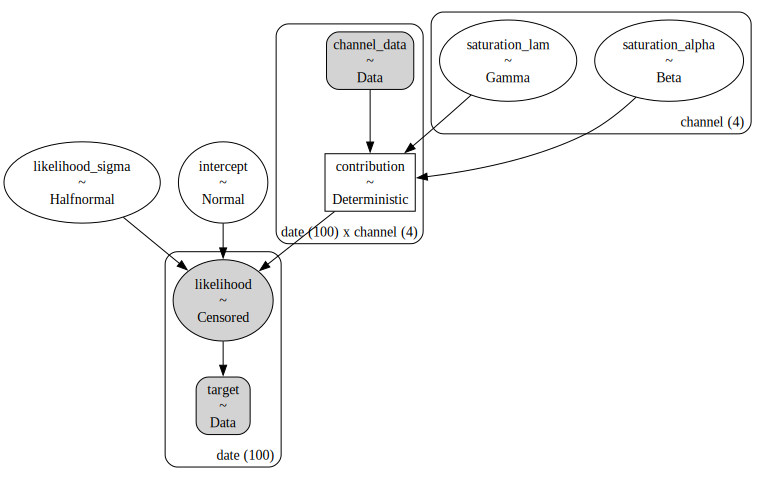

In [ ]:
base_model = build_simple_mmm(dataset, coordinates, "y")
base_model.to_graphviz()

Using this simple structure, we can now generate the target variable based on fixed parameters. To do so, we'll use the `pm.do` function from PyMC. You can [read more about it here](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html).

We'll set a grid of true parameters (the ones the model should be able to recover) for our model's internal functions.

In [ ]:
first_model_grid = {
    "intercept": 0.5,
    "saturation_lam": np.array([0.1, 0.3, 1, 0.8]),
    "saturation_alpha": np.array([0.3, 0.5, 4, 3]),
    "likelihood_sigma": 0.05,
}
first_model = pm.do(base_model, first_model_grid)

In [ ]:
second_model_grid = {
    "intercept": 0.5,
    "saturation_lam": np.array([1, 0.8, 0.6, 0.2]),
    "saturation_alpha": np.array([4, 3, 0.4, 0.5]),
    "likelihood_sigma": 0.09,
}
second_model = pm.do(base_model, second_model_grid)

Now that our **true models** are defined, we can draw from the fixed parameters to generate data. This will help us create a dataset with two target variables. Both are dependent on the same inputs, but while they are generated similarly, their weights are different.

:::{note}
This will position us in the situation we want: *two different outcomes, driven by the same drivers*.
:::

In [ ]:
dataset["y_first_model"] = pm.draw(first_model["likelihood"])
dataset["y_second_model"] = pm.draw(second_model["likelihood"])
dataset.head()

,date,impressions_x1_var,impressions_x2_var,impressions_x3_var,impressions_x4_var,y,y_first_model,y_second_model
0,2020-01-01,0.866098,0.948983,1.686121,1.372259,0,5.562658,4.738537
1,2020-01-02,1.208886,0.929276,1.724699,1.247626,0,5.498952,5.077095
2,2020-01-03,1.571934,0.934704,1.561938,1.325415,0,5.390272,5.381136
3,2020-01-04,1.316408,0.942521,1.697812,1.473127,0,5.588847,5.024071
4,2020-01-05,1.468910,0.899849,1.712968,1.365724,0,5.674915,5.198630


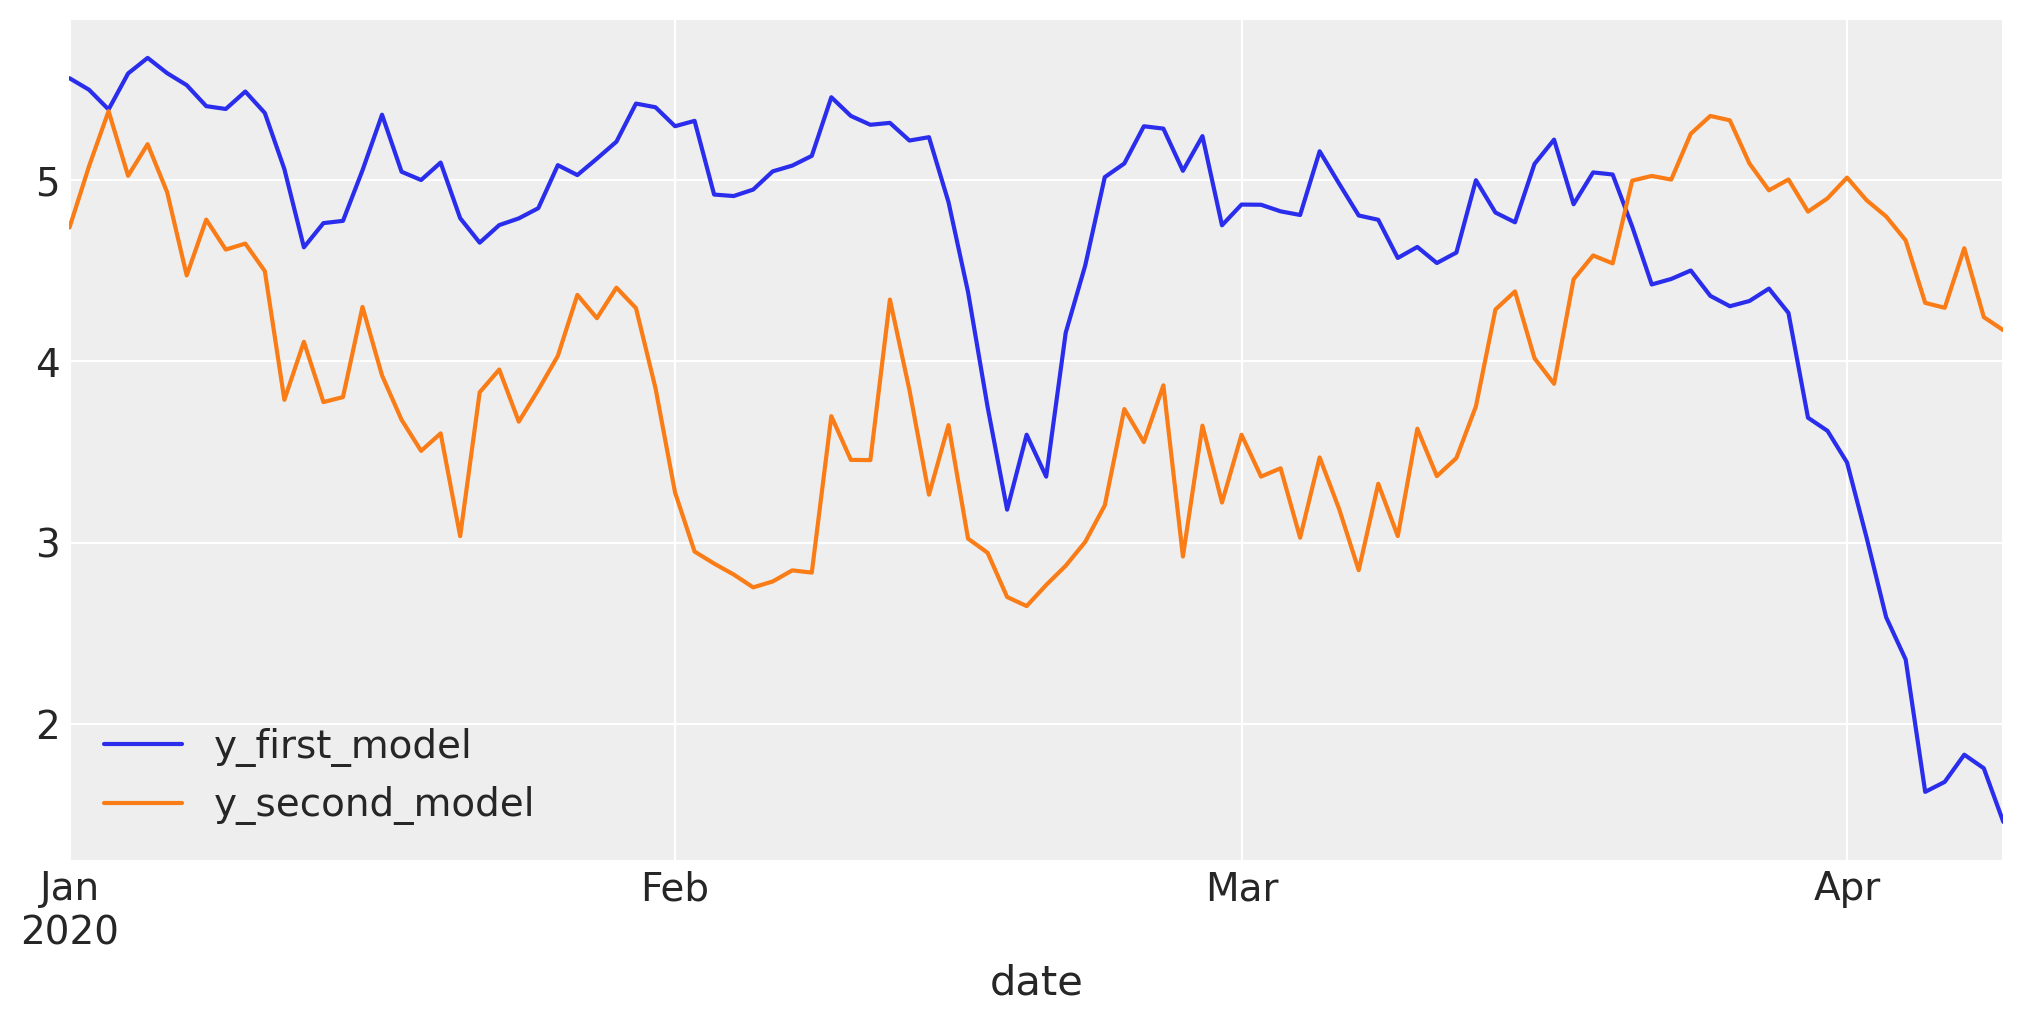

In [ ]:
dataset.set_index("date")[["y_first_model", "y_second_model"]].plot(figsize=(10, 5))
plt.show()

This looks fantastic! Our outcomes are quite different, even though the internal variables are the same. This is where the real challenge begins.

Because we have two different target variables, we can say, "*Let's build two different models, one for each target variable.*" This is a promising idea, and we can simulate this situation using our `build_simple_mmm` function again.

In [ ]:
new_users_model = build_simple_mmm(dataset, coordinates, "y_first_model")
reengage_users_model = build_simple_mmm(dataset, coordinates, "y_second_model")

With our two models built, we can now train them!

In [ ]:
sample_grid = {
    "draws": 200,
    "tune": 800,
    "chains": 4,
    "target_accept": 0.84,
}

In [ ]:
with new_users_model:
    new_users_idata = pm.sample(**sample_grid)
with reengage_users_model:
    reengage_users_idata = pm.sample(**sample_grid)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [saturation_alpha, saturation_lam, intercept, likelihood_sigma]


Output()

Sampling 4 chains for 800 tune and 200 draw iterations (3_200 + 800 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [saturation_alpha, saturation_lam, intercept, likelihood_sigma]


Output()

Sampling 4 chains for 800 tune and 200 draw iterations (3_200 + 800 draws total) took 1 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Now that both of our models are trained on our data, we can proceed with optimization.

Before optimizing, we need to wrap our models in a protocol that allows the optimizer to use them. We have built a small wrapper to make any PyMC model compatible quickly.

In [ ]:
CustomModelWrapper?

Init signature:
CustomModelWrapper(
    base_model: pymc.model.core.Model,
    idata: arviz.data.inference_data.InferenceData,
    channels: collections.abc.Sequence[str],
) -> None
Docstring:      Wrapper for the BudgetOptimizer to handle custom PyMC models.
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises [`ValidationError`][pydantic_core.ValidationError] if the input data cannot be
validated to form a valid model.

`self` is explicitly positional-only to allow `self` as a field name.
File:           ~/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/budget_optimizer.py
Type:           ModelMetaclass
Subclasses:     

You only need to provide your channel list (you can use the model coordinates for this), the `idata`, and the PyMC model object.

::: {tip}
Building a custom class wrapper is quite easy. Your model only needs to follow the protocol in `OptimizerCompatibleModelWrapper`. Internally, you can customize it as much as you want.
:::

In [ ]:
new_users_optimizable_model = CustomModelWrapper(
    base_model=new_users_model,
    idata=new_users_idata,
    channels=coordinates["channel"],
)

reengage_optimizable_model = CustomModelWrapper(
    base_model=reengage_users_model,
    idata=reengage_users_idata,
    channels=coordinates["channel"],
)

Once your model is wrapped, we must create a custom objective function that allows you to work with the variable to be optimized. Our model has the deterministic variable `contribution`, which has the dimensions `sample, date, channel`. The optimizer works with the posterior over all dimensions, meaning we need to collapse the `date` and `channel` dimensions.

Take a look at how it works!

In [ ]:
def average_response(
    samples: pt.TensorVariable, budgets: pt.TensorVariable
) -> pt.TensorVariable:
    """Compute the average response of the posterior predictive distribution."""
    return pt.mean(_check_samples_dimensionality(samples.sum(axis=(1, 2))))

With our function in place, all we need to do is define our optimization horizon, and we are set. We pass our variable to be optimized and the utility function that gets this variable and performs an operation. In this case, it takes the mean value of the posterior from the total contribution over channels and days.

Because we have two models, we will run two optimizations. Take a moment to look in detail at how the optimizer must be called 🙌🏻

In [ ]:
optimization_horizon = 10
budget_per_time_unit_in_horizon = 2
optimizer_new_users = BudgetOptimizer(
    model=new_users_optimizable_model,
    num_periods=optimization_horizon,
    response_variable="contribution",
    utility_function=average_response,
)
allocation_new_users, result_new_users = optimizer_new_users.allocate_budget(
    total_budget=budget_per_time_unit_in_horizon,
)

optimizer_reengage = BudgetOptimizer(
    model=reengage_optimizable_model,
    num_periods=optimization_horizon,
    response_variable="contribution",
    utility_function=average_response,
)
allocation_reengage, result_reengage = optimizer_reengage.allocate_budget(
    total_budget=budget_per_time_unit_in_horizon,
)

Once both optimizations are complete, we can observe the results!

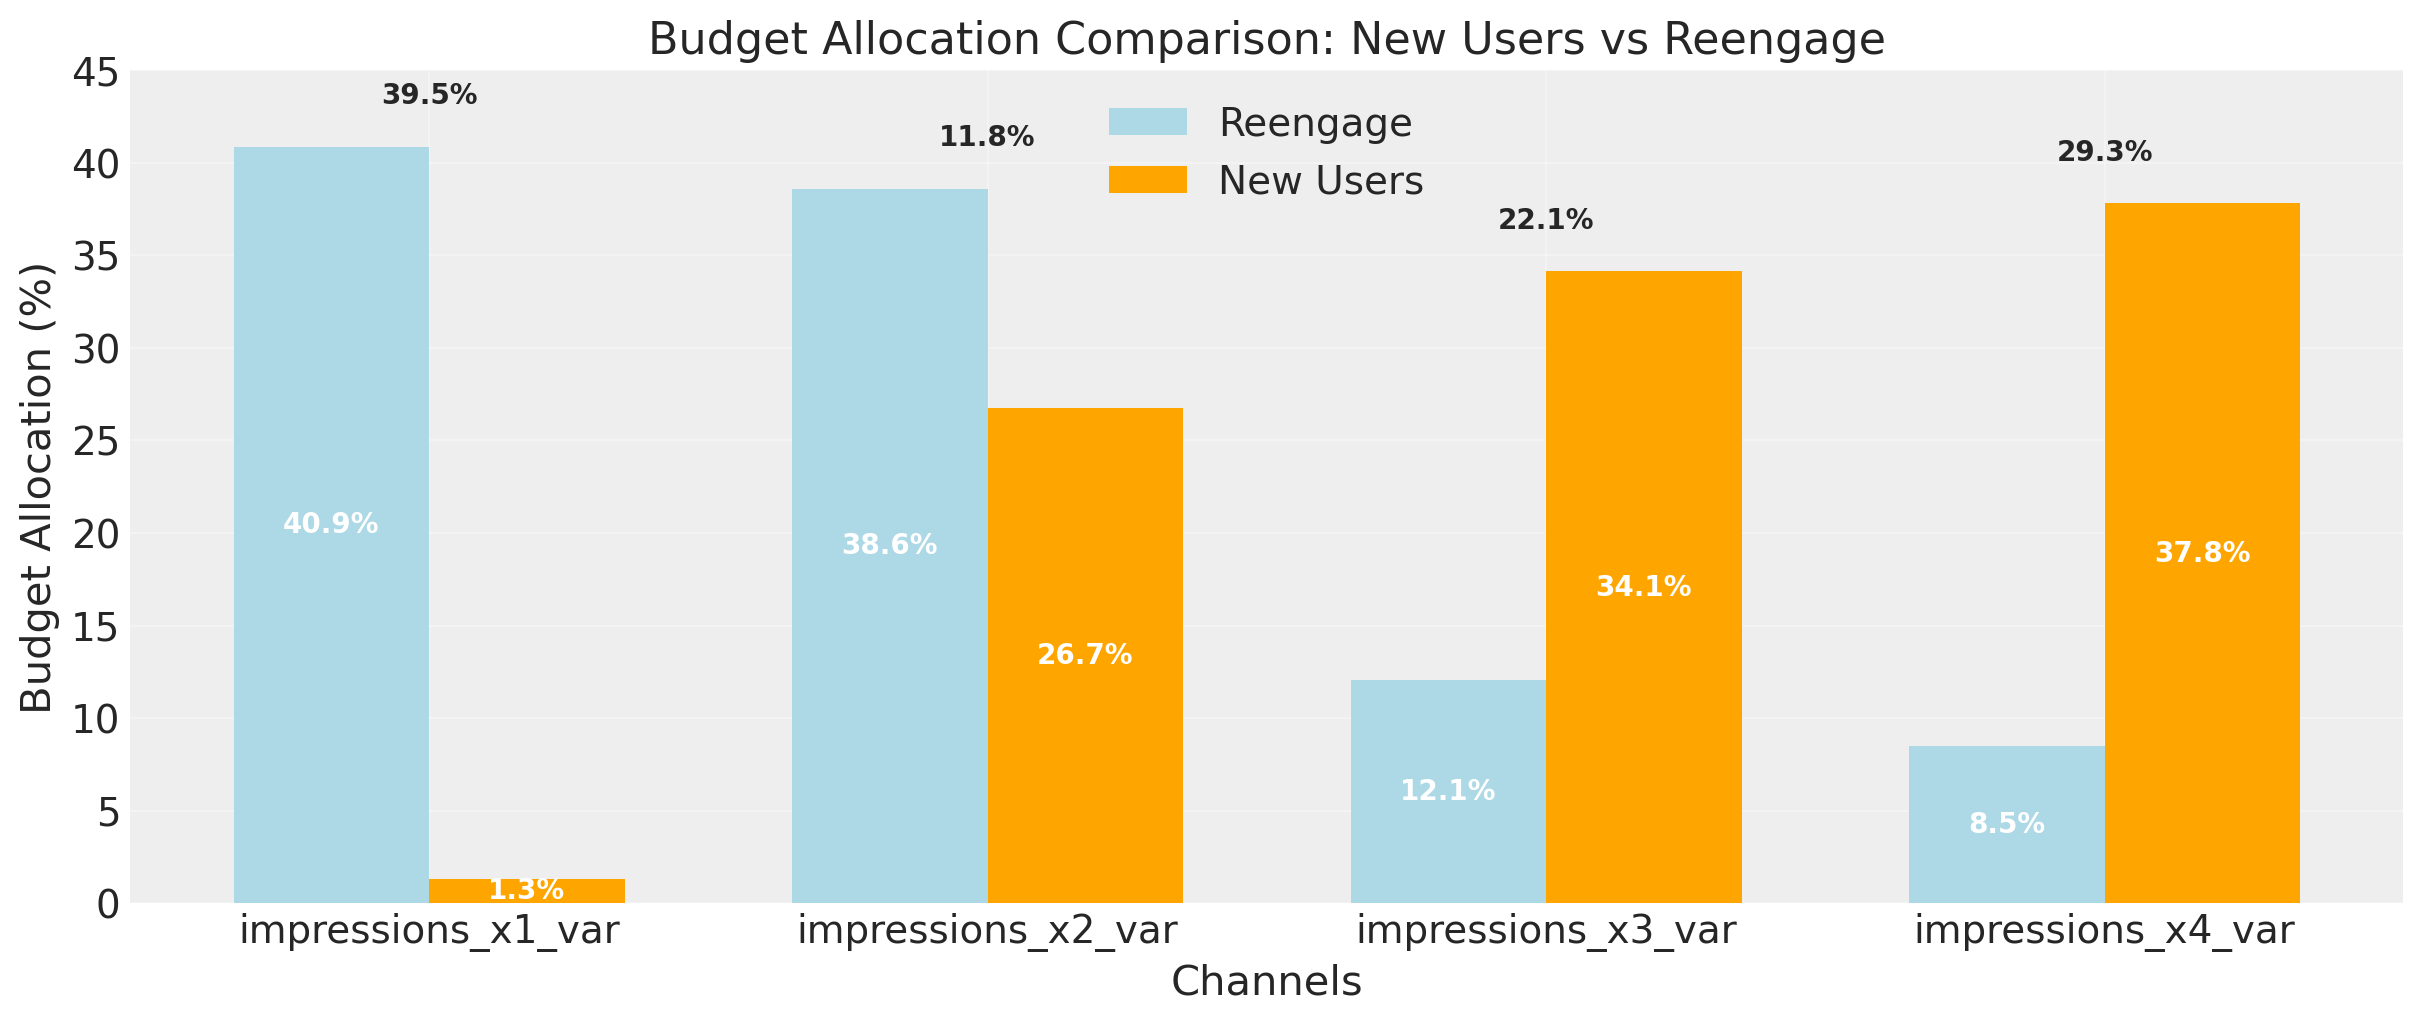

In [ ]:
# Normalize allocations by budget per time unit and convert to percentages
_normalize_factor = 100
allocation_reengage_norm = (
    allocation_reengage.values / budget_per_time_unit_in_horizon
) * _normalize_factor
allocation_new_users_norm = (
    allocation_new_users.values / budget_per_time_unit_in_horizon
) * _normalize_factor

# Get channel names from coordinates
channel_names = allocation_reengage.coords["channel"].values

# Calculate absolute differences
abs_diff = np.abs(allocation_new_users_norm - allocation_reengage_norm)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(channel_names))
width = 0.35

# Create bars
bars1 = ax.bar(
    x - width / 2, allocation_reengage_norm, width, label="Reengage", color="lightblue"
)
bars2 = ax.bar(
    x + width / 2, allocation_new_users_norm, width, label="New Users", color="orange"
)

# Add value labels inside bars (white text)
for _i, (bar1, bar2) in enumerate(zip(bars1, bars2, strict=False)):
    # Reengage values
    height1 = bar1.get_height()
    if height1 > 0:
        ax.text(
            bar1.get_x() + bar1.get_width() / 2.0,
            height1 / 2,
            f"{height1:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

    # New Users values
    height2 = bar2.get_height()
    if height2 > 0:
        ax.text(
            bar2.get_x() + bar2.get_width() / 2.0,
            height2 / 2,
            f"{height2:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

    # Add absolute difference on top
    max_height = max(height1, height2)
    ax.text(
        x[_i],
        max_height + 2,
        f"{abs_diff[_i]:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Customize plot
ax.set_xlabel("Channels")
ax.set_ylabel("Budget Allocation (%)")
ax.set_title("Budget Allocation Comparison: New Users vs Reengage")
ax.set_xticks(x)
ax.set_xticklabels(channel_names)
ax.set_ylim(0, 45)
ax.grid(True, alpha=0.3)
ax.legend()

plt.show()

In [ ]:
print(f"New Users given marketing budget: {abs(result_new_users['fun'])}")
print(f"Reengage given marketing budget: {abs(result_reengage['fun'])}")

New Users given marketing budget: 14.891877735595886
Reengage given marketing budget: 12.225768720711883


The picture makes everything crystal clear: the channels that drive new users are not the same as those that drive re-engaged users. This is problematic because if we want to optimize for new users, our allocation is directionally different from the one for re-engaged users.

We can see that both responses are similar in terms of the budget, but the budget allocations for those responses change radically. To visualize this phenomenon better, we can compute the response distributions.

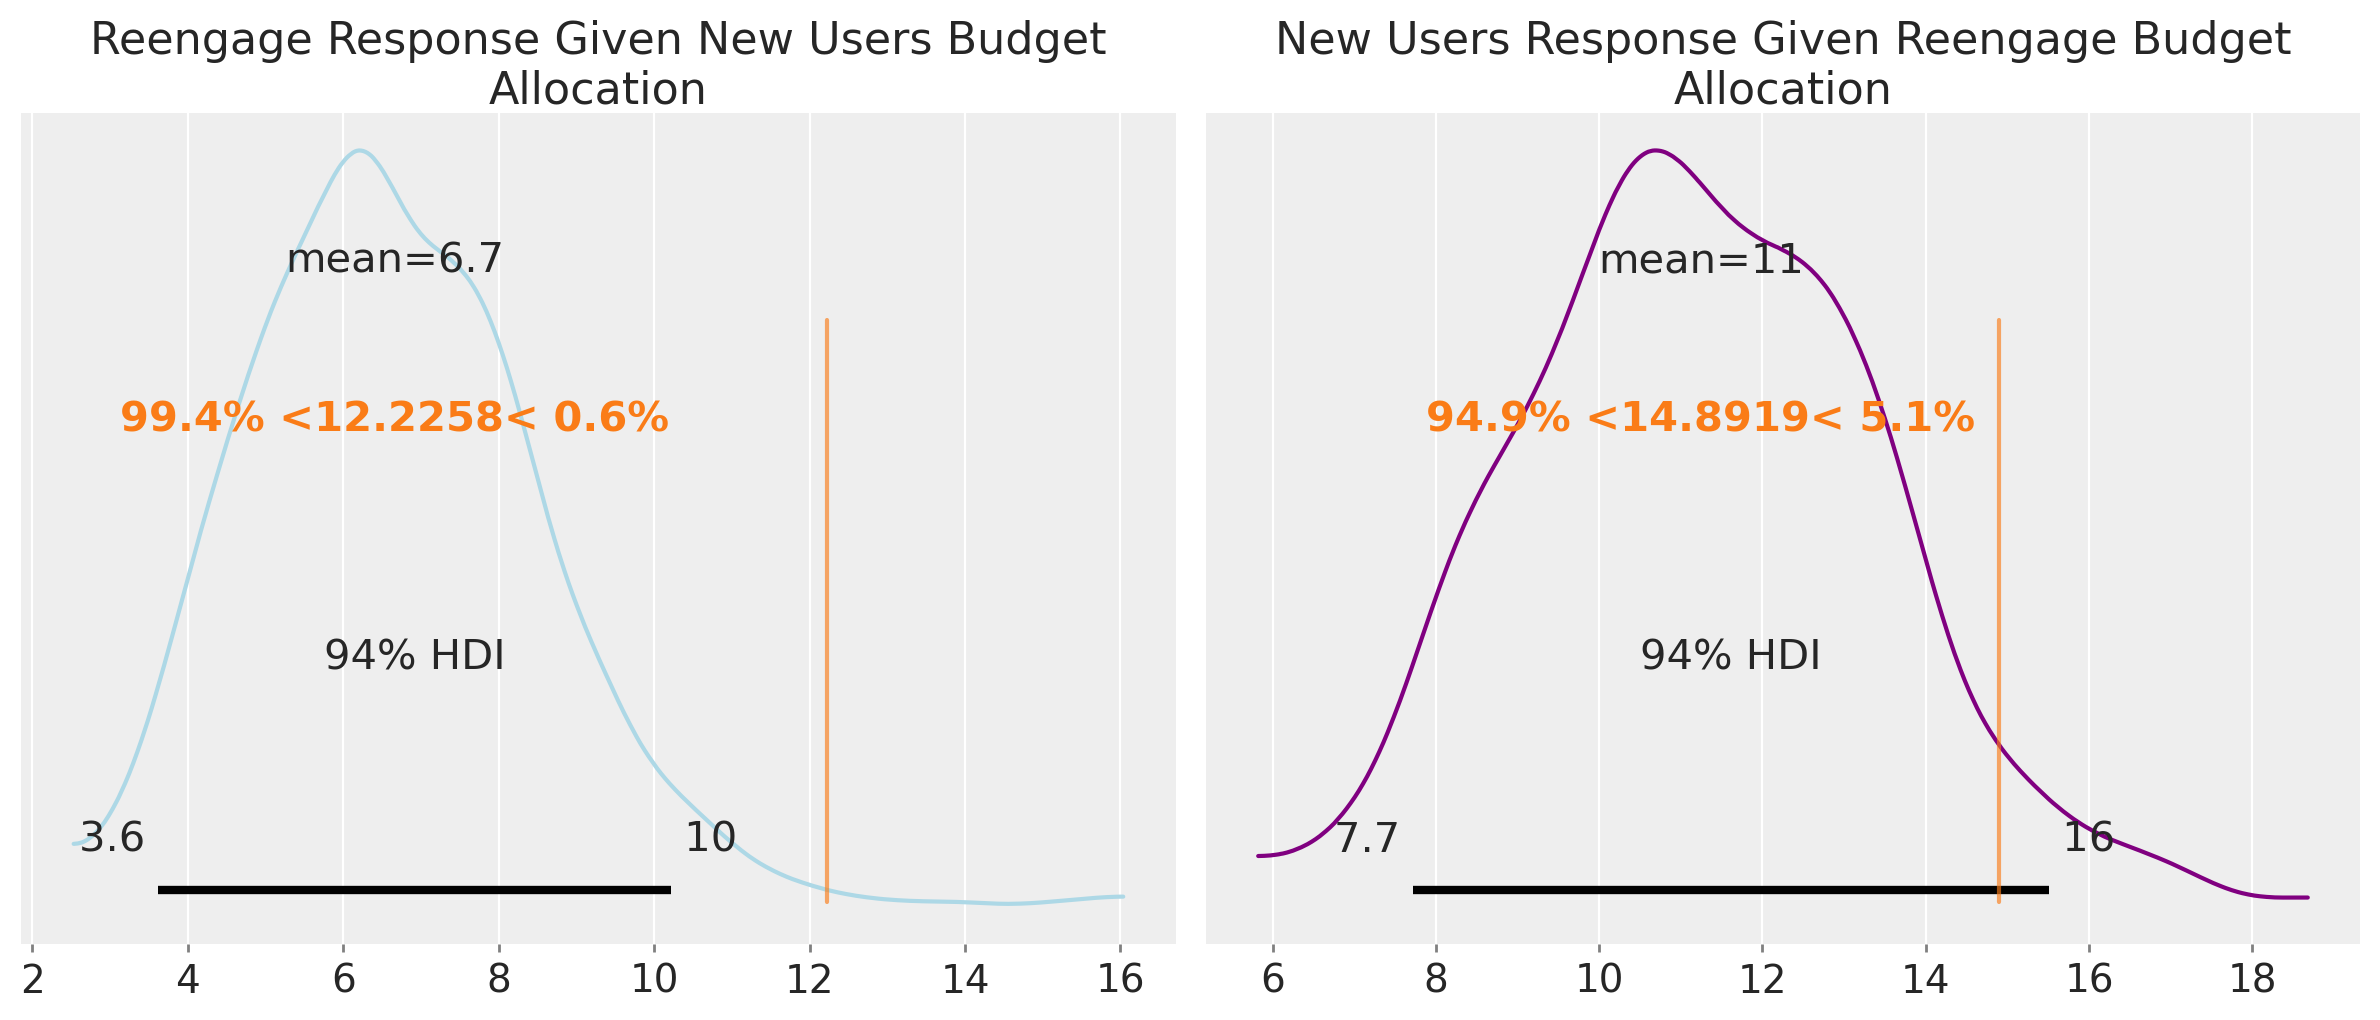

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

_distribution = optimizer_reengage.extract_response_distribution("contribution").sum(
    axis=(1, 2)
)
_distribution_func = function([optimizer_reengage._budgets_flat], _distribution)
posterior_reengage_given_new_users_budget_allocation = _distribution_func(
    allocation_new_users.values
)
az.plot_posterior(
    posterior_reengage_given_new_users_budget_allocation,
    color="lightblue",
    # label=f"Total response of reengage given new users budget allocation",
    ref_val=round(abs(result_reengage["fun"]), 4),
    ax=axes[0],
)
axes[0].set_title("Reengage Response Given New Users Budget Allocation")

_distribution = optimizer_new_users.extract_response_distribution("contribution").sum(
    axis=(1, 2)
)
_distribution_func = function([optimizer_new_users._budgets_flat], _distribution)
posterior_new_users_given_reengage_budget_allocation = _distribution_func(
    allocation_reengage.values
)
az.plot_posterior(
    posterior_new_users_given_reengage_budget_allocation,
    color="purple",
    # label=f"Total response of new users given reengage budget allocation",
    ref_val=round(abs(result_new_users["fun"]), 4),
    ax=axes[1],
)
axes[1].set_title("New Users Response Given Reengage Budget Allocation")

plt.tight_layout()
plt.show()

This makes everything clear: if we use the budget recommendation from the new users model, we will get a good number of new users, but we'll penalize re-engaged users, getting 40% fewer than we could with the same budget distributed differently. A similar story unfolds if we use the recommendation for re-engaged users; we then penalize new users.

How can we create an optimization problem that considers both responses and finds a solution that doesn't penalize any target metric? The answer is the `BuildMergedModel` class.

In [ ]:
BuildMergedModel?

Init signature:
BuildMergedModel(
    models: list[pymc_marketing.mmm.budget_optimizer.OptimizerCompatibleModelWrapper],
    prefixes: list[str] | None = None,
    merge_on: str | None = 'channel_data',
    use_every_n_draw: int = 1,
) -> None
Docstring:     
Merge multiple optimizer-compatible models into a single model.

This wrapper combines several optimizer-compatible MMM wrappers by:
- Merging their posterior `InferenceData` with per-model prefixes
- Optionally thinning posterior draws via ``use_every_n_draw``
- Exposing a persistent merged PyMC ``Model`` for optimization through
  ``_set_predictors_for_optimization`` and a dynamic ``model`` property for
  inspection when needed

Parameters
----------
models : list[OptimizerCompatibleModelWrapper]
    A list of wrappers that each expose ``idata`` and
    ``_set_predictors_for_optimization(num_periods: int) -> Model``.
prefixes : list[str] | None, optional
    Per-model prefixes used when merging. If ``None``, defaults to
    ``["

The `BuildMergedModel` class is designed to merge multiple optimizer-compatible models into a single unified graphical representation. This is achieved by combining the posterior `InferenceData` from each model with unique prefixes, allowing for the integration of multiple models' outputs into a cohesive framework. The class operates in a symbolic graphical space, where models are treated as generative processes that can be combined similarly to SQL queries. This approach enables the seamless merging of models by aligning and merging dimensions based on a shared variable, typically referred to as `merge_on`. The merged model is then exposed as a persistent PyMC model, which can be used for further optimization and analysis.

Let's take a look at how it works!

In [ ]:
merged_model = BuildMergedModel(
    models=[new_users_optimizable_model, reengage_optimizable_model],
    prefixes=["new_users", "reengage"],
    merge_on="channel_data",
    use_every_n_draw=1,
)

Now that the model is merged, we can reformulate the optimization process. Maximizing two variables, such as new user acquisition and re-engagement, is inherently challenging because they represent different units and objectives. Attempting to maximize both simultaneously leads to an infinite solution space, as improving one objective often comes at the expense of the other.

However, we can reformulate the problem by maximizing one variable while holding the other as a constraint. This approach allows the optimizer to focus on maximizing a single objective while ensuring that the other variable remains above a specified threshold $Z$, which represents our minimum goal for that "*secondary objective*".

Here, we are saying we want a budget that brings in at least 10 (thousand or million) re-engaged users, and that new users should be maximized as long as that constraint is met.

In [ ]:
min_total_response = 10


def mean_response_eq_constraint_fun(budgets_sym, total_budget_sym, optimizer):
    """Enforces mean_response(budgets_sym) = target_response, i.e. returns (mean_resp - target_response)."""
    resp_dist = optimizer.extract_response_distribution("reengage_contribution")
    mean_resp = pt.mean(_check_samples_dimensionality(resp_dist.sum(axis=(1, 2))))
    return mean_resp - min_total_response


optimizer = BudgetOptimizer(
    model=merged_model,
    num_periods=optimization_horizon,
    response_variable="new_users_contribution",
    utility_function=average_response,
    custom_constraints=[
        Constraint(
            key="min_response_constraint",
            constraint_fun=mean_response_eq_constraint_fun,
            constraint_type="ineq",
        )
    ],
)

In [ ]:
allocation, result, callback_results = optimizer.allocate_budget(
    total_budget=budget_per_time_unit_in_horizon,
    callback=True,
)

The optimization is now performed using a merged model that combines multiple deterministic variables (objective variables). As a consequence, we can use any of them in any part of the optimization.

:::{tip}
You can create any type of objective function. This is just an example, so be as creative as you want. As long as your objective is feasible, the optimizer can handle the rest.
:::

In [ ]:
constraint_value = round(callback_results[-1]["constraint_info"][0]["value"], 4)
# Check if constraint is satisfied (should be close to zero for equality, >= 0 for inequality)
if np.isclose(constraint_value, 0, atol=1e-6):
    print(f"Constraint satisfied: value {constraint_value} is close to zero")
elif constraint_value > 0:
    print(f"Constraint satisfied: value {constraint_value} is greater than zero")
else:
    raise ValueError(f"Constraint violated: value {constraint_value} should be >= 0")

Constraint satisfied: value -0.0 is close to zero


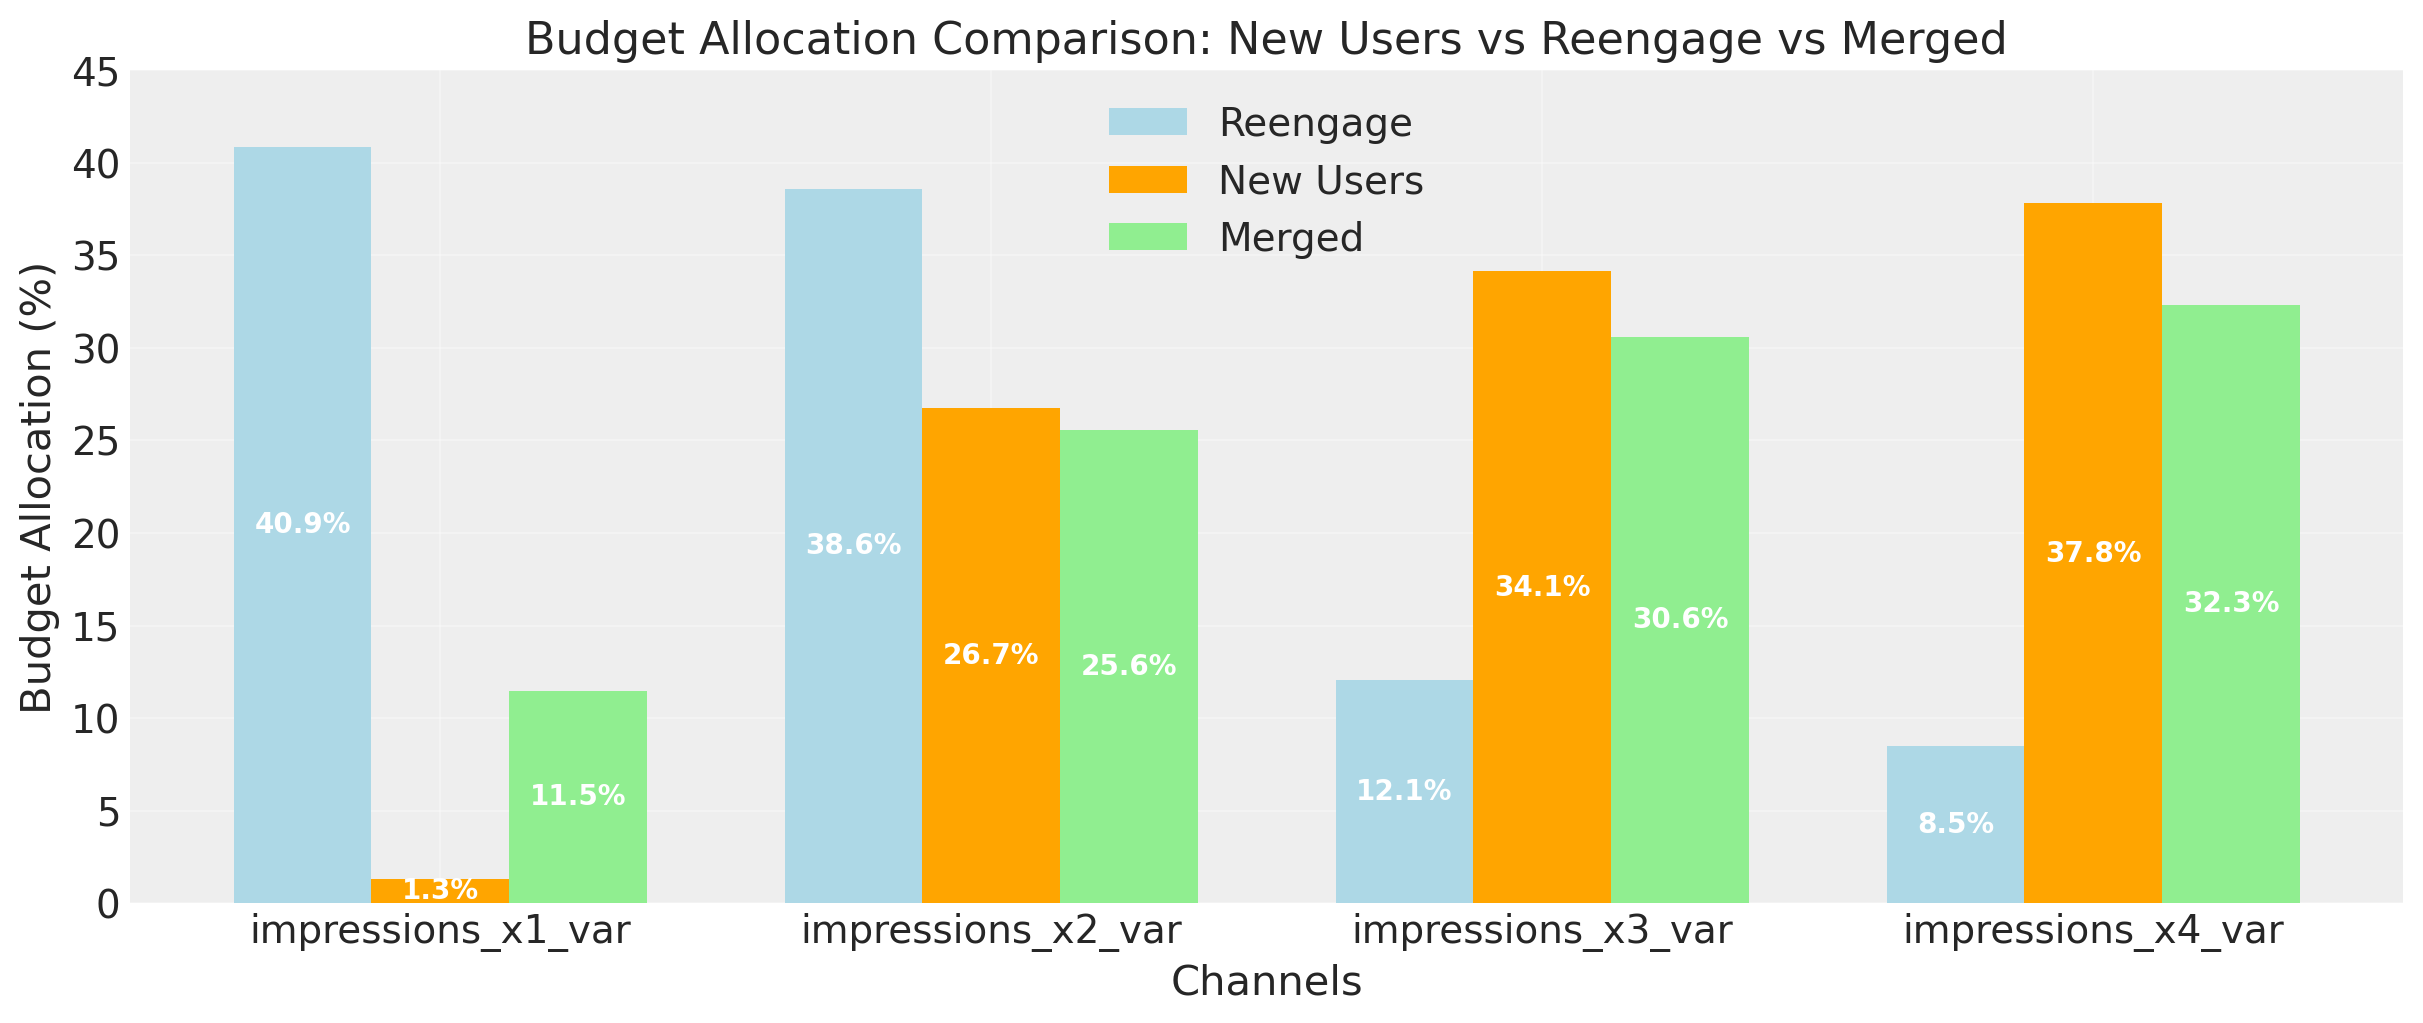

In [ ]:
merged_allocation_norm = (
    allocation.values / budget_per_time_unit_in_horizon
) * _normalize_factor

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(channel_names))
width = 0.25

# Create bars
bars1 = ax.bar(
    x - width, allocation_reengage_norm, width, label="Reengage", color="lightblue"
)
bars2 = ax.bar(x, allocation_new_users_norm, width, label="New Users", color="orange")
bars3 = ax.bar(
    x + width, merged_allocation_norm, width, label="Merged", color="lightgreen"
)

# Add value labels inside bars (white text)
for _i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3, strict=False)):
    # Reengage values
    height1 = bar1.get_height()
    if height1 > 0:
        ax.text(
            bar1.get_x() + bar1.get_width() / 2.0,
            height1 / 2,
            f"{height1:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

    # New Users values
    height2 = bar2.get_height()
    if height2 > 0:
        ax.text(
            bar2.get_x() + bar2.get_width() / 2.0,
            height2 / 2,
            f"{height2:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

    # Merged values
    height3 = bar3.get_height()
    if height3 > 0:
        ax.text(
            bar3.get_x() + bar3.get_width() / 2.0,
            height3 / 2,
            f"{height3:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

# Customize plot
ax.set_xlabel("Channels")
ax.set_ylabel("Budget Allocation (%)")
ax.set_title("Budget Allocation Comparison: New Users vs Reengage vs Merged")
ax.set_xticks(x)
ax.set_xticklabels(channel_names)
ax.set_ylim(0, 45)
ax.grid(True, alpha=0.3)
ax.legend()

plt.show()

Amazing! The new allocation is more balanced between channels, showing that we are not optimizing for a single objective. 👏🏻

What else can we do? Let's now look at an example using a native `MMM` model from PyMC-Marketing.

## Optimizing MultiDimensional MMM Models

With the PyMC-Marketing class, the process barely changes:

1. We load or build our MMM model (Multidimensional or not).
2. We wrap the model in the optimizer class (avoid this if you are using the old API).
3. We pass the new merged model to the budget optimizer.

In [ ]:
data_path = data_dir / "multidimensional_mock_data.csv"
data_df = pd.read_csv(data_path, parse_dates=["date"], index_col=0)
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

In [ ]:
mmm1 = build_mmm_from_yaml(
    X=x_train,
    y=y_train,
    config_path=data_dir / "config_files" / "multi_dimensional_example_model.yml",
)

mmm2 = build_mmm_from_yaml(
    X=x_train,
    y=y_train,
    config_path=data_dir / "config_files" / "multi_dimensional_example_model.yml",
)

mmm3 = build_mmm_from_yaml(
    X=x_train,
    y=y_train,
    config_path=data_dir / "config_files" / "multi_dimensional_example_model.yml",
)

Once the models are built, we use the wrappers!

In [ ]:
max_date = new_users_idata.posterior.coords["date"].max().item()
start_date = (pd.Timestamp(max_date) + pd.Timedelta(weeks=1)).strftime("%Y-%m-%d")

end_date = (
    pd.Timestamp(start_date) + pd.Timedelta(weeks=optimization_horizon)
).strftime("%Y-%m-%d")

w1 = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm1, start_date=start_date, end_date=end_date
)
w2 = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm2, start_date=start_date, end_date=end_date
)
w3 = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm3, start_date=start_date, end_date=end_date
)

merged = BuildMergedModel(
    models=[w1, w2, w3],
    prefixes=["north", "south", "west"],
    merge_on="channel_data",
    use_every_n_draw=5,
)

Done! Our merged model is ready to use. Let's visualize it.

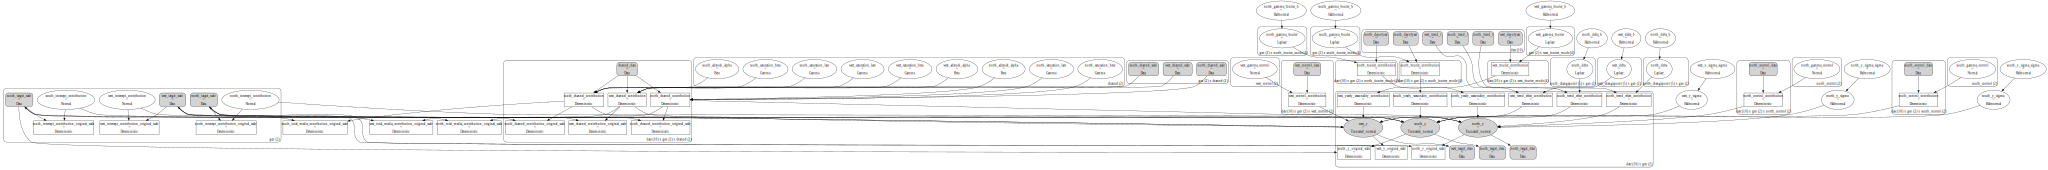

In [ ]:
merged.model.to_graphviz()

We'll play here with another option (something different than before). Once our model is ready, we can merge and add a new variable that is dependent on pre-existing deterministic variables from our different models. This can help create a deterministic variable that represents the total units across our models.

We just need to access the model and create the deterministic variable.

In [ ]:
with merged.model:
    pm.Deterministic(
        name="new_variable_calculation",
        var=(
            merged.model["north_total_media_contribution_original_scale"]
            + merged.model["south_total_media_contribution_original_scale"]
            + merged.model["west_total_media_contribution_original_scale"]
        ),
    )

Now, we can ask the optimizer to do something similar to what it did before: bring me the maximum number of units across all markets (models), but keep a specific market at a level greater than or equal to $Z$.

Check how this works 👇🏻

In [ ]:
min_total_response = 10


def mean_response_eq_constraint_fun(budgets_sym, total_budget_sym, optimizer):
    """Enforces mean_response(budgets_sym) = target_response, i.e. returns (mean_resp - target_response)."""
    resp_dist = optimizer.extract_response_distribution(
        "north_total_media_contribution_original_scale"
    )
    mean_resp = pt.mean(_check_samples_dimensionality(resp_dist))
    return mean_resp - min_total_response


optimize_multidimensional_merged_model = BudgetOptimizer(
    model=merged,
    num_periods=optimization_horizon,
    response_variable="new_variable_calculation",  # variable to optimize (maximize in this case)
    custom_constraints=[
        Constraint(
            key="min_response_constraint",
            constraint_fun=mean_response_eq_constraint_fun,
            constraint_type="ineq",
        )
    ],
)

allocation_xarray, scipy_result, callback_results = (
    optimize_multidimensional_merged_model.allocate_budget(
        total_budget=budget_per_time_unit_in_horizon, callback=True
    )
)

In [ ]:
constraint_value = round(callback_results[-1]["constraint_info"][0]["value"], 4)
# Check if constraint is satisfied (should be close to zero for equality, >= 0 for inequality)
if np.isclose(constraint_value, 0, atol=1e-6):
    print(f"Constraint satisfied: value {constraint_value} is close to zero")
elif constraint_value > 0:
    print(f"Constraint satisfied: value {constraint_value} is greater than zero")
else:
    raise AssertionError(
        f"Constraint violated: value {constraint_value} should be >= 0"
    )

Constraint satisfied: value 240.8141 is greater than zero


[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/importlib/__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


Great! Again, we can see that the optimizer found a solution and finished the task while respecting the constraints.

The `BuildMergedModel` class allows for a huge range of new capabilities in optimization. You can merge your pre-existing trained models into a single place and optimize whatever you like, thinking about and adjusting the objective based on your business needs. But at the same time, that's just the tip of the iceberg.

### Learning about the merge models function
Under the hood, the `BuildMergedModel` class is based on the `merge_models` function in `pytensor_utils`, which allows you to apply the same merge operation without `idata`. This allows you to create models from other models and then sample them together if needed.

In [ ]:
merge_models?

Signature:
merge_models(
    models: list[pymc.model.core.Model],
    *,
    prefixes: list[str] | None = None,
    merge_on: str | None = None,
) -> pymc.model.core.Model
Docstring:
Merge multiple PyMC models into a single model.

Parameters
----------
models : list of pm.Model
    List of models to merge.
prefixes : list of str or None
    List of prefixes for each model. If None, will auto-generate as 'model1', 'model2', ...
merge_on : str or None
    Variable name to merge on (shared across all models) - this variable will NOT be prefixed.

Returns
-------
pm.Model
    Merged model.
File:      ~/Documents/GitHub/pymc-marketing/pymc_marketing/pytensor_utils.py
Type:      function

In this symbolic graphical space, each model acts as a node in a computational directed acyclic graph (C-DAG), and the merging process is akin to performing a join operation in SQL, where different datasets are combined based on common keys. By leveraging the power of PyMC and the symbolic representation of models, `merge_models` facilitates the construction of these large graphical models without the need to build them all together from scratch. You can always build and combine different pieces, like with **Lego**.

Check out how, using this lower-level function, we can use the pure PyMC models and get a new model from them.

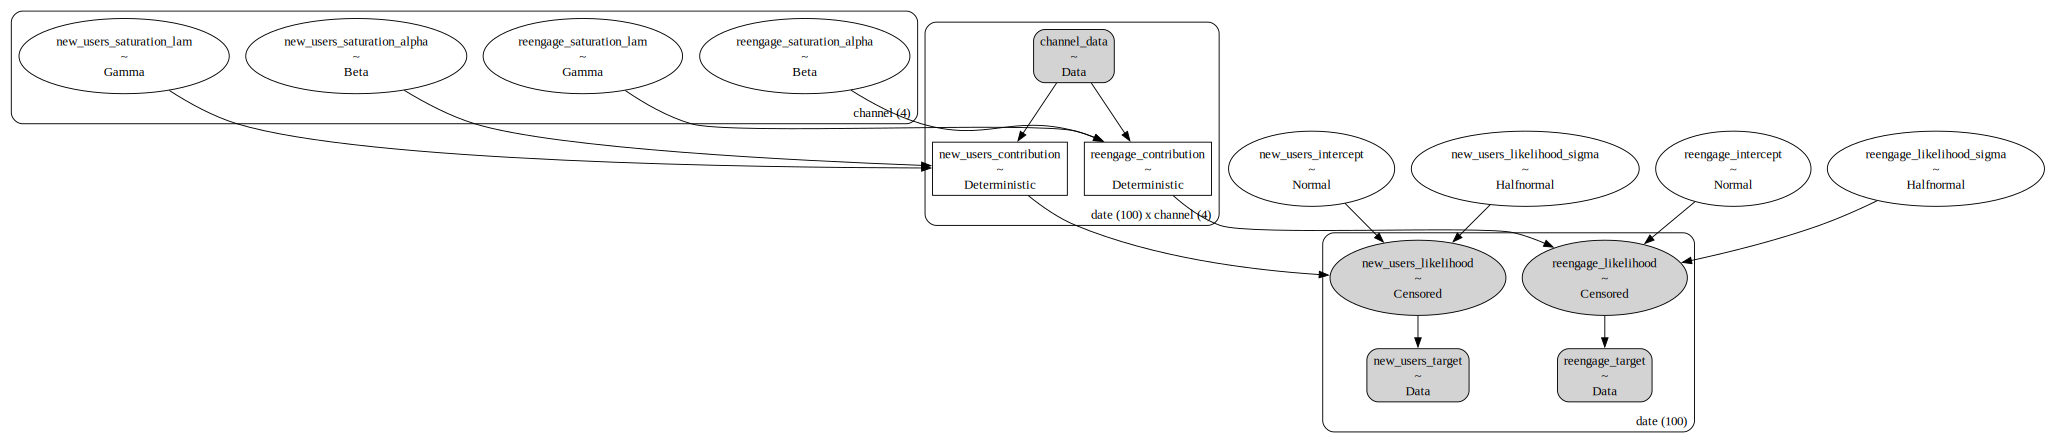

In [ ]:
pm_merge_model = merge_models(
    models=[new_users_model, reengage_users_model],
    prefixes=["new_users", "reengage"],
    merge_on="channel_data",
)
pm_merge_model.to_graphviz()

Now that the model is built, we can sample from it like any other PyMC model.

In [ ]:
with pm_merge_model:
    merged_model_idata = pm.sample(**sample_grid)
merged_model_idata

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [new_users_saturation_alpha, new_users_saturation_lam, new_users_intercept, new_users_likelihood_sigma, reengage_saturation_alpha, reengage_saturation_lam, reengage_intercept, reengage_likelihood_sigma]


Output()

Sampling 4 chains for 800 tune and 200 draw iterations (3_200 + 800 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Is this model different from sampling two models separately? It shouldn't be. This is merging all your variables and keeping every deterministic or random variable with a prefix. This means the nodes don't interact or pull information from each other; the models are fully independent even when they share the same variable. This is equivalent to running separate models in parallel.

Let's see how the posterior for a given parameter looks against the individual model.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

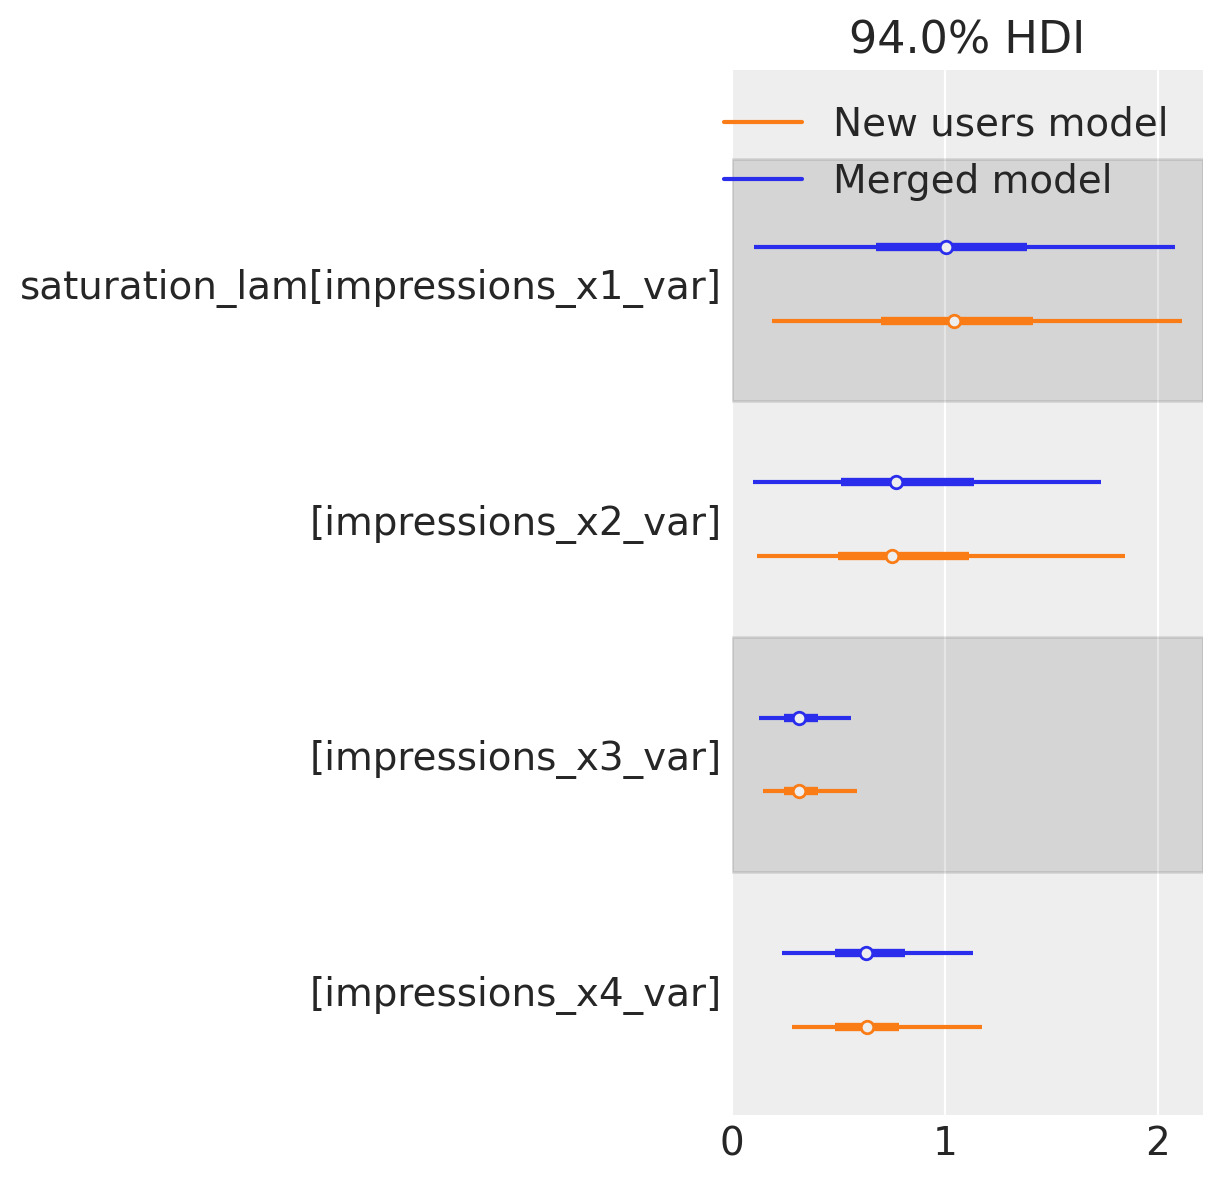

In [ ]:
temp = merged_model_idata.copy()
# rename new_users_saturation_lam to saturation_lam
temp.rename({"new_users_saturation_lam": "saturation_lam"}, inplace=True)

az.plot_forest(
    data=[temp.posterior.saturation_lam, new_users_idata.posterior.saturation_lam],
    model_names=["Merged model", "New users model"],
    var_names=["saturation_lam"],
    combined=True,
)

The recovered parameter is the same!

Nevertheless, the biggest benefit of combining the models is being able to connect or relate the variables. Not only for optimization, but during sampling, you could add penalty terms on a variable of a model A, which, if related to model B, could condition the values for the parameters of model B.

Depending on the model, a possible benefit or problem could be the sampling time. This can vary quite a bit once you start making these large graphical models.

To estimate sampling times for any PyMC model, you can use the `ModelSamplerEstimator` utility class from `pytensor_utils`.

In [ ]:
from pymc_marketing.pytensor_utils import ModelSamplerEstimator

ModelSamplerEstimator?

Init signature:
ModelSamplerEstimator(
    *,
    tune: int = 1000,
    draws: int = 1000,
    chains: int = 1,
    sequential_chains: int = 1,
    seed: int | None = None,
) -> None
Docstring:     
Estimate computational characteristics of a PyMC model using JAX/NumPyro.

This utility measures the average evaluation time of the model's logp and gradients
and estimates the number of integrator steps taken by NUTS during warmup + sampling.
It then compiles the information into a single-row pandas DataFrame with helpful
metadata to guide planning and benchmarking.

Parameters
----------
tune : int, default 1000
    Number of warmup iterations to use when estimating NUTS steps.
draws : int, default 1000
    Number of sampling iterations to use when estimating NUTS steps.
chains : int, default 1
    Intended number of chains (metadata only; not used in JAX runs here).
sequential_chains : int, default 1
    Number of chains expected to run sequentially on the target environment.
    Used to

Once we initialize the class, we can pass a model to it and get back the sampling estimation in different time units. See the example below!

In [ ]:
estimator = ModelSamplerEstimator()
estimated_model_time = estimator.run(pm_merge_model)
# change model name of index zero to pm_merge_model
estimated_model_time.loc[0, "model"] = "pm_merge_model"
estimated_model_time

,model_name,num_steps,eval_time_seconds,sequential_chains,estimated_sampling_time_seconds,estimated_sampling_time_minutes,estimated_sampling_time_hours,tune,draws,chains,seed,timestamp,model
0,,60750,0.000057,1,3.49119,0.058186,0.00097,1000,1000,1,None,2025-10-05 13:46:45+00:00,pm_merge_model


Doing the same, we can now estimate the time for our individual models.

In [ ]:
new_users_time = estimator.run(new_users_model)
new_users_time.loc[0, "model"] = "new_users_model"
estimated_model_time = pd.concat(
    [estimated_model_time, new_users_time], ignore_index=True
)

reengage_users_time = estimator.run(reengage_users_model)
reengage_users_time.loc[0, "model"] = "reengage_users_model"
estimated_model_time = pd.concat(
    [estimated_model_time, reengage_users_time], ignore_index=True
)

In [ ]:
print(
    "Merged model: Assuming 1000 draws and tunes over 4 chains, the minimum time to sample the merged model is: ",
    estimated_model_time.query("model == 'pm_merge_model'")[
        "estimated_sampling_time_seconds"
    ].values,
    "seconds",
)

print(
    "New users model: Assuming 1000 draws and tunes over 4 chains, the minimum time to sample the new users model is: ",
    estimated_model_time.query("model == 'new_users_model'")[
        "estimated_sampling_time_seconds"
    ].values,
    "seconds",
)

print(
    "Re-engage users model: Assuming 1000 draws and tunes over 4 chains, "
    "the minimum time to sample the re-engage users model is: ",
    estimated_model_time.query("model == 'reengage_users_model'")[
        "estimated_sampling_time_seconds"
    ].values,
    "seconds",
)

Merged model: Assuming 1000 draws and tunes over 4 chains, the minimum time to sample the merged model is:  [3.49118969] seconds
New users model: Assuming 1000 draws and tunes over 4 chains, the minimum time to sample the new users model is:  [1.64929952] seconds
Re-engage users model: Assuming 1000 draws and tunes over 4 chains, the minimum time to sample the re-engage users model is:  [2.01107886] seconds


In [ ]:
estimated_model_time.head()

,model_name,num_steps,eval_time_seconds,sequential_chains,estimated_sampling_time_seconds,estimated_sampling_time_minutes,estimated_sampling_time_hours,tune,draws,chains,seed,timestamp,model
0,,60750,0.000057,1,3.491190,0.058186,0.000970,1000,1000,1,None,2025-10-05 13:46:45+00:00,pm_merge_model
1,,44739,0.000037,1,1.649300,0.027488,0.000458,1000,1000,1,None,2025-10-05 13:46:50+00:00,new_users_model
2,,56816,0.000035,1,2.011079,0.033518,0.000559,1000,1000,1,None,2025-10-05 13:46:55+00:00,reengage_users_model


## Conclusion

The main focus of this notebook is a powerful technique: combining different probabilistic models to create a unified framework for decision-making. We showed how the `BuildMergedModel` class can smoothly integrate various models, whether they are custom PyMC models or complex MultiDimensional MMMs from the `pymc-marketing` library. This method allows us to tackle tricky trade-offs—like maximizing new users while also re-engaging existing ones—by reformulating the problem as a constrained optimization. We can maximize one objective while ensuring another meets a minimum performance level, which helps us find a balanced budget allocation without compromising important business objectives.

However, this is not just about marketing. The techniques presented here demonstrate a flexible and scalable approach to computational modeling. By building models in a modular, 'Lego-like' fashion using the `merge_models` function, we can create complex graphical models that truly capture the connections within business systems. This opens up possibilities for detailed scenario planning and optimization in various areas, such as finance, operations, or product development. Plus, with tools like `ModelSamplerEstimator` to estimate computational costs, practitioners can handle the complexities of larger models. This provides a practical and powerful framework for data-driven strategic planning in any organization.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Oct 05 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pytensor: 2.31.7

matplotlib    : 3.10.3
pymc_marketing: 0.16.0
pymc_extras   : 0.4.0
pymc          : 5.25.1
numpy         : 2.2.6
pytensor      : 2.31.7
arviz         : 0.22.0
pandas        : 2.3.1

Watermark: 2.5.0

